In [ ]:
import pandas as pd
import seaborn as sns
import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import tensorflow as tf
# import tensorflow.compat.v1 as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
import os, sys, time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from collections import OrderedDict
# from tensorflow.python.ops import math_ops
# import tensorflow.keras.backend as kb
from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
_check_tf_version()
from tensorflow_addons import losses

# Custom Functions
# Added to path by using sys.path.append('')
sys.path.append('/home/akanu/git/anomalous_pred/custom_functions')
from load_data import Files_Load, Boxes, test_split_norm_abnorm, norm_train_max_min
from custom_metrics import bb_intersection_over_union, bb_intersection_over_union_np
from coordinate_change import xywh_tlbr, tlbr_xywh
from pedsort import pedsort

# Kmeans
from sklearn.cluster import KMeans

# Need to figue out why this is not working
# from persistence1d import RunPersistence


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
plt.style.use('classic')

# GPU Check

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


In [ ]:
tf.config.list_physical_devices('GPU')

In [5]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[1],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5500)])
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


# Load Data

In [7]:
frames = 20
# startvid=0
# endvid=21

train_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Train_Box/"
test_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/"

loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load(train_file, test_file)

# Don't forget to change to xywh 
traindict = Boxes(loc_files_train, box_train_txt, frames, pad ='pre', to_xywh=True)
testdict = Boxes(loc_files_test, box_test_txt, frames, pad ='pre', to_xywh = True)
abnormal_dict, normal_dict = test_split_norm_abnorm(testdict) #splits by which predicted frames are normal or not

# Normilize data
max1 = traindict['x_ppl_box'].max()
min1 = traindict['x_ppl_box'].min()
xx,yy = norm_train_max_min(data_dict = traindict, max1=max1,min1=min1)
xx_norm,yy_norm = norm_train_max_min(data_dict = normal_dict, max1=max1,min1=min1)
xx_abnorm,yy_abnorm = norm_train_max_min(data_dict = abnormal_dict, max1=max1,min1=min1)


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
xx_train, xx_val,yy_train,yy_val = train_test_split(xx,yy, test_size = 0.3)
train_univariate = tf.data.Dataset.from_tensor_slices((xx_train,yy_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate = tf.data.Dataset.from_tensor_slices((xx_val,yy_val))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Train Model

In [9]:
print(sys.path)

['', '/opt/ros/melodic/lib/python2.7/dist-packages', '/home/akanu/.virtualenvs/anomalous_pred/lib/python36.zip', '/home/akanu/.virtualenvs/anomalous_pred/lib/python3.6', '/home/akanu/.virtualenvs/anomalous_pred/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '/home/akanu/.virtualenvs/anomalous_pred/lib/python3.6/site-packages', '/home/akanu/.virtualenvs/anomalous_pred/lib/python3.6/site-packages/IPython/extensions', '/tmp/tmpk8ouelf3', '/home/akanu/git/anomalous_pred/custom_functions']


In [10]:
# sys.path.insert(0,'/home/akanu/git/anomalous_pred/model')
# from lstm_models import lstm_xywh_avenue_20


In [11]:
model_loc = '/home/akanu/git/anomalous_pred/saved_models'
nc=['lstm', 'xywh', 'avenue', frames]

In [12]:

# lstm_20 = lstm_xywh_avenue_20(train_data = train_univariate,
#                               val_data = val_univariate,
#                               model_loc = model_loc,
#                               nc=nc,
#                               epochs=300)


NameError: name 'lstm_20' is not defined

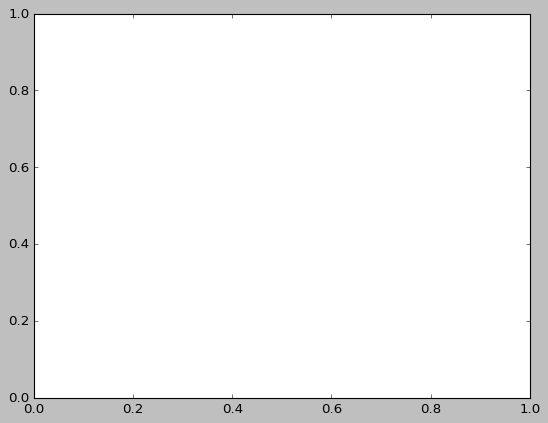

In [13]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(lstm_20.history['val_loss'],'-o',label='Validation Set')
ax.plot(lstm_20.history['loss'], '-*', label='Train Set')
image_loc = '/home/akanu/git/anomalous_pred/model/plots_models'
image = 'loss_{}_{}_{}_{}.jpg'
ax.legend()
plt.title('Loss')
plt.savefig(os.path.join(image_loc,image.format(nc[0], nc[1],nc[2], nc[3])))

# Load Model (If model is trained)

In [14]:
loaded_model = os.path.join(model_loc,'{}_{}_{}_{}.h5'.format(nc[0], nc[1],nc[2], nc[3]))
model = tf.keras.models.load_model(loaded_model,  
                                   custom_objects = {'loss':'mse'} , 
                                   compile=True)
lstm_20 = model
# Appears because of my custom loss fuction I could use evaluate

# Plot Data

In [15]:
# pic_loc = "/home/akanu/git/anomalous_pred/resulting_images/xywh/test_abnorm/{}_{}_{}"
# visual_ouput(model=lstm_20,max1 = max1, min1=min1, vid=1,pic_loc =pic_loc, output_dict=abnormal_dict,xywh = True)

In [ ]:
# pic_loc = "/home/akanu/git/anomalous_pred/resulting_images/xywh/test_norm/{}_{}_{}"
# visual_ouput(model=lstm_20,max1 = max1, min1=min1, vid=1,pic_loc =pic_loc, output_dict=normal_dict,xywh = True)

# Sorting data

Whats going on right here is that you are loading all the dataset at once.
As a result when you say pedsort['1'] its not as meaning one person who is at in
one video but person one from all the videos in that dataset.
(when you load all the videos at the same time).
To fix it would just need to for loop it and save dict to another dict
Would have a unique dict set for each video, then another dict set containing 
each person. Then inside that another dict set with the unful information

In [ ]:
j ='1'
ped = pedsort(testdict)
x,y = norm_train_max_min(data_dict=ped[j], max1 = max1, min1=min1 )

In [ ]:
out1 = lstm_20.predict(x)


out = bb_intersection_over_union_np(xywh_tlbr(out1), xywh_tlbr(y))
plt.plot(ped[j]['frame_ppl_id'][:,-1,0], np.squeeze(out),'-')
plt.plot(ped[j]['frame_ppl_id'][:,-1,0], ped[j]['abnormal'])
plt.xlabel('Frame')
plt.ylabel('IOU')
print(np.mean(out), out.shape)
# sns.distplot(np.squeeze(out))

In [ ]:
out1.shape

# Using averaged iou to find Abnormal vs normal
## Doesn't work well

In [ ]:
# Tries to find normal/abnormal pedestrian from averaged iou
iou_sum = []
for j in ped.keys():
#     print(j)
    x,y = norm_train_max_min(data_dict=ped[j], max1 = max1, min1=min1 )
    out1 = lstm_20.predict(x)
    out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
#     print(out.shape)
    iou_sum.append([np.mean(out), np.any(ped[j]['abnormal']) ])
iou_sum = np.array(iou_sum)

In [ ]:
abnormal_ped = iou_sum[np.nonzero(iou_sum[:,1])]

In [ ]:
norm_ped = iou_sum[np.where(iou_sum[:,1]==0)]

In [ ]:

plt.plot(norm_ped[:,0],'-*', label='normal')
plt.plot(abnormal_ped[:,0], '-+', label='abnormal')
plt.xlabel('pedestrian')
plt.ylabel('Averaged IOU over time')
plt.legend()
# sns.distplot(norm_ped[:,0])
# sns.distplot(abnormal_ped[:,0])

# Finding distribution of normal vs abnormal pedestrains

In [ ]:
iou_abnorm = []
iou_norm = []
for j in ped.keys():
#     print(j)
    x,y = norm_train_max_min(data_dict=ped[j], max1 = max1, min1=min1 )
    out1 = lstm_20.predict(x)
    out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
#     print(out.shape)
    if np.any(ped[j]['abnormal']):
#         iou_abnorm.append(np.squeeze(out).tolist()[:])
        iou_abnorm += np.squeeze(out).tolist()
    else:
#         iou_norm.append(np.squeeze(out).tolist())
        iou_norm += np.squeeze(out).tolist()

# iou_abnorm = np.array(iou_abnorm)
# iou_norm = np.array(iou_norm)


In [ ]:
sns.distplot(iou_abnorm, label='abnormal pedestrain')
sns.distplot(iou_norm, label='normal pedestrain')
plt.title('Test Video 1')
plt.legend()

In [ ]:
len(testdict['abnormal'])

# Finding distrubtions of Normal vs abnormal frames

In [ ]:
startvid =0
endvid=21

testdict = Boxes(loc_files_test[startvid:endvid], box_test_txt[startvid:endvid], frames, pad ='pre', to_xywh = True)

In [ ]:
frames

In [ ]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out1 = lstm_20.predict(x)
out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
out = np.squeeze(out)
#     print(out.shape)
norm_index = np.where(testdict['abnormal']== 0)
abnorm_index = np.where(testdict['abnormal']== 1)


In [ ]:
len(abnorm_index[0])

In [ ]:
sns.distplot(out[abnorm_index], label='abnormal frames')
sns.distplot(out[norm_index], label='normal frames')
plt.title('All Test Video ')
plt.legend()

# Binary Classification on frames

In [ ]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out1 = lstm_20.predict(x)
out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
out = np.squeeze(out)
np.random.seed(49)
rand = np.random.permutation(len(out))


In [ ]:
def create_baseline():
    with tf.device('/device:GPU:0'):
        # create model
        model = keras.Sequential()
        model.add(keras.layers.Dense(1, input_dim=1, activation='relu'))
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

In [ ]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=32, verbose=0)

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)


In [ ]:
results = cross_val_score(estimator, out[rand], testdict['abnormal'][rand], cv=kfold)

In [ ]:
print("Baseline: %.2f%% (%.8f%%)" % (results.mean()*100, results.std()*100))

# Binary classifcation Even Split

In [ ]:
startvid =0
endvid=21

testdict = Boxes(loc_files_test[startvid:endvid], box_test_txt[startvid:endvid], frames, pad ='pre', to_xywh = True)


In [ ]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out1 = lstm_20.predict(x)
out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
out = np.squeeze(out)
np.random.seed(49)
rand = np.random.permutation(len(out))

In [ ]:
abnorm_index = np.where(testdict['abnormal']==1)
norm_index = np.where(testdict['abnormal'] == 0)

In [ ]:
print('abnormal: {}, normal: {}'.format(len(abnorm_index[0]), len(norm_index[0])))
# Want to create a function that allows me to vary the amount of abnormalites in the trainingg loader
# Want to also be able to vary amount of norms in training loader
# Need to keep track of indexes so that I can assign correct ones to abnormal truth

In [ ]:
weight_scale = 1

In [ ]:
# def vary_abnormal_normal_frames():
    abnormal_split = 0.5
    val_split = 0.3
    
    abnorm_index = np.where(testdict['abnormal']==1)
    norm_index = np.where(testdict['abnormal'] == 0)
    rand_abn = np.random.permutation(len(abnorm_index[0]))
    rand_n = np.random.permutation(len(norm_index[0]))
    abnorm_index = abnorm_index[0][rand_abn]
    norm_index = norm_index[0][rand_n]
    
    len_abn_split = int(len(abnorm_index)*abnormal_split)
    a = abnorm_index[:len_abn_split]
    b = norm_index[:len_abn_split*weight_scale]
    
    len_val_split = int(val_split*len(a) )
    
    val_a = a[:len_val_split]
    val_b = b[:len_val_split*weight_scale] # allows me to change % of normals
    
    test_a = a[len_val_split:]
    test_b = b[len_val_split*weight_scale:]
    
    c = abnorm_index[len_abn_split:]
    d = norm_index[len_abn_split*weight_scale:]

    train_x_an = out[ test_a]
    train_y_an= testdict['abnormal'][ test_a ]
    
    train_x_n = out[ test_b]
    train_y_n = testdict['abnormal'][ test_b ]
    
    train_x = np.append(train_x_an,train_x_n,axis =0)
    train_y = np.append(train_y_an,train_y_n, axis = 0 )
    
    
    val_x_an = out[ val_a]
    val_y_an= testdict['abnormal'][ val_a ]
    
    val_x_n = out[ val_b]
    val_y_n = testdict['abnormal'][ val_b ]
    
    val_x = np.append(val_x_an,val_x_n,axis =0)
    val_y = np.append(val_y_an,val_y_n, axis = 0 )
       
    
    
    
    test_x_an = out[ c ]
    test_y_an= testdict['abnormal'][ c]
    
    test_x_n = out[ d ] 
    test_y_n = testdict['abnormal'][ d ]
    
    test_x = np.append(test_x_an, test_x_n, axis = 0)
    test_y = np.append(test_y_an, test_y_n, axis = 0)

    

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
train_univariate_1 = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_univariate_1 = train_univariate_1.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate_1 = tf.data.Dataset.from_tensor_slices((val_x,val_y))
val_univariate_1 = val_univariate_1.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_univariate_1 = tf.data.Dataset.from_tensor_slices((test_x,test_y))
train_univariate_1 = train_univariate_1.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
def create_baseline():
    with tf.device('/device:GPU:0'):
        # create model
        neurons = 20
        dropout_ratio = 0.3
        model = keras.Sequential()
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dropout(dropout_ratio))
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dropout(dropout_ratio))
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

In [ ]:
# np.random.seed(49)
# rand = np.random.permutation(len(out))
# size = 115624
# test ={}

# for i in testdict.keys():
#     testdict[i] = testdict[i][rand]

In [ ]:
binary_model = create_baseline()

In [ ]:
binary_model.summary()

In [ ]:
# x_train,x_test,y_train, y_test =train_test_split(out[rand], testdict['abnormal'][rand],shuffle=False,test_size=.5)
# Bad thing is can't guantree how many samples of abnormal is in x_train,x_test

In [ ]:
# x_train,x_test,y_train, y_test =train_test_split(out, testdict['abnormal'],shuffle=False,test_size=.9)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, 
                                                  patience=10, restore_best_weights=True)

In [ ]:
bm = binary_model.fit(train_univariate_1, validation_data=val_univariate_1, epochs=300,callbacks=early_stopping)

In [ ]:
plt.plot(bm.history['val_loss'], label='val_loss')
plt.plot(bm.history['loss'], label='loss')
plt.legend()



In [ ]:
bm.history.keys()

In [ ]:
plt.plot(bm.history['val_accuracy'], label='val_acc')
plt.plot(bm.history['accuracy'], label='acc')
plt.legend()

In [ ]:
y_pred = binary_model.predict(test_x)
plt.plot(y_pred, '*')

In [ ]:
y_pred = binary_model.predict(test_x) > 0.5
tf.math.confusion_matrix(test_y,y_pred , num_classes = 2)

Their does not seem to be a need to create a custom loss.
Reason is that weihted_cross_entropy_with_logits exists

# Weighted loss

In [16]:
startvid =0
endvid=21

testdict = Boxes(loc_files_test[startvid:endvid], box_test_txt[startvid:endvid], frames, pad ='pre', to_xywh = True)


In [17]:
weight_scale = 10
# initial_bias = np.log([ratio/(ratio*weight_scale)])
initial_bias = np.log([1/weight_scale])

In [18]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out1 = lstm_20.predict(x)
out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
out = np.squeeze(out)
np.random.seed(49)
rand = np.random.permutation(len(out))

In [22]:
# def vary_abnormal_normal_frames():

    # Finds Abnormal index
    abnorm_index = np.where(testdict['abnormal']==1)
    norm_index = np.where(testdict['abnormal'] == 0)
#     rand_an = np.random.permutation(len(abnorm_index[0]))
#     rand_n = np.random.permutation(len(abnormabnorm_index[0]))
#     abnorm_index = abnorm_index[0][rand_an]
#     norm_index = norm_index[0][rand_n]
    
    abnormal_ratio = 0.5
    val_ratio = 0.2
    
    
    len_abn_split = int(len(abnorm_index[0])*abnormal_ratio)
    
    # Index for the training set before being split
    # Weight scale allows for a much higher factor of 
    # normal values to exist
    abn = abnorm_index[0][:len_abn_split]
    norm = norm_index[0][:len_abn_split*weight_scale]
    

    
    len_val_split = int(val_ratio*len(abn) )
    
    # NOte how len_val_split is used in  val_a , val_b, 
    val_abn= abn[:len_val_split]
    val_norm = norm[:len_val_split*weight_scale]
    
    train_abn = abn[len_val_split:]
    train_norm = norm[len_val_split*weight_scale:]
    
    
    test_abn = abnorm_index[0][len_abn_split:]
    test_norm = norm_index[0][len_abn_split*weight_scale:]
    
    
    
    train_x_an = out[ train_abn]
    train_y_an= testdict['abnormal'][ train_abn ]
    
    train_x_n = out[ train_norm]
    train_y_n = testdict['abnormal'][ train_norm ]
    
    train_x = np.append(train_x_an,train_x_n,axis =0)
    train_y = np.append(train_y_an,train_y_n, axis = 0 )
    
    
    val_x_an = out[ val_abn]
    val_y_an= testdict['abnormal'][ val_abn ]
    
    val_x_n = out[ val_norm]
    val_y_n = testdict['abnormal'][ val_norm ]
    
    val_x = np.append(val_x_an,val_x_n,axis =0)
    val_y = np.append(val_y_an,val_y_n, axis = 0 )
       
    
    
    
    test_x_an = out[ test_abn ]
    test_y_an= testdict['abnormal'][ test_abn]
    
    test_x_n = out[ test_norm] 
    test_y_n = testdict['abnormal'][ test_norm ]
    
    test_x = np.append(test_x_an, test_x_n, axis = 0)
    test_y = np.append(test_y_an, test_y_n, axis = 0)
    
#     return 
   

In [24]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
train_univariate = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate = tf.data.Dataset.from_tensor_slices((val_x,val_y))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [25]:
initial_bias = np.log([1/weight_scale])


In [26]:
initial_bias

array([-2.30258509])

In [27]:
print('training')
print('abnormal_mean: {}, normal_mean: {}'.format(train_x_an.mean(), train_x_n.mean()))
print('abnormal_mean: {}, normal_mean: {}'.format(train_y_an.mean(), train_y_n.mean()))
print("\n")

print('testing')
print('abnormal_mean: {}, normal_mean: {}'.format(test_x_an.mean(), test_x_n.mean()))
print('abnormal_mean: {}, normal_mean: {}'.format(test_y_an.mean(), test_y_n.mean()))

training
abnormal_mean: 0.35722096144359106, normal_mean: 0.7117016293432692
abnormal_mean: 1.0, normal_mean: 0.0


testing
abnormal_mean: 0.5232399121272329, normal_mean: 0.6946333595456928
abnormal_mean: 1.0, normal_mean: 0.0


In [28]:
def weighted_binary(y,x):
    return tf.nn.weighted_cross_entropy_with_logits(y,x,pos_weight = weight_scale)

In [29]:
x = tf.constant([.8], dtype=tf.float32)

In [30]:
y = tf.constant([1], dtype=tf.float32)

In [31]:
 tf.nn.weighted_cross_entropy_with_logits(y,x,pos_weight = 1)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.37110066], dtype=float32)>

In [32]:
tf.keras.losses.binary_crossentropy(y, x, from_logits=True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.37110066>

In [33]:
def create_baseline_weighted(output_bias = None):
    with tf.device('/device:GPU:0'):
        # create model
        if output_bias is not None:
            output_bias = keras.initializers.Constant(output_bias)
        neurons = 30
        dropout_ratio = 0.3
        model = keras.Sequential()
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dense(neurons, activation='relu'))
        model.add(keras.layers.Dropout(dropout_ratio))
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dense(neurons, input_dim=1, activation='relu'))
        model.add(keras.layers.Dropout(dropout_ratio))
        model.add(keras.layers.Dense(1, bias_initializer=output_bias))
        # Compile model
#         wce = tf.nn.weighted_cross_entropy_with_logits(pos_weight = 10)
        model.compile(loss=weighted_binary, optimizer='adam', metrics=['accuracy'])
        return model

In [34]:
model_wl = create_baseline_weighted( )
model_wl.layers[-1].bias.assign([0.0])


<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [35]:
model_wl.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3

In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0005, 
                                                  patience=10, restore_best_weights=True)

In [37]:
model_wl.predict(test_x).min()

0.0

In [38]:
wbm = model_wl.fit(train_univariate, validation_data=val_univariate, epochs=300,callbacks = early_stopping)

Epoch 1/300
403/403 [==============================] - 2s 5ms/step - loss: 0.9001 - accuracy: 0.8658 - val_loss: 0.5545 - val_accuracy: 0.8759
Epoch 2/300
403/403 [==============================] - 2s 5ms/step - loss: 0.7208 - accuracy: 0.8284 - val_loss: 0.5915 - val_accuracy: 0.8526
Epoch 3/300
403/403 [==============================] - 2s 5ms/step - loss: 0.7101 - accuracy: 0.8307 - val_loss: 0.6022 - val_accuracy: 0.8247
Epoch 4/300
403/403 [==============================] - 2s 5ms/step - loss: 0.7104 - accuracy: 0.8294 - val_loss: 0.6063 - val_accuracy: 0.8328
Epoch 5/300
403/403 [==============================] - 2s 5ms/step - loss: 0.7077 - accuracy: 0.8297 - val_loss: 0.6117 - val_accuracy: 0.8210
Epoch 6/300
403/403 [==============================] - 2s 5ms/step - loss: 0.6964 - accuracy: 0.8252 - val_loss: 0.5483 - val_accuracy: 0.8998
Epoch 7/300
403/403 [==============================] - 2s 5ms/step - loss: 0.7039 - accuracy: 0.8283 - val_loss: 0.6273 - val_accuracy: 0.8666

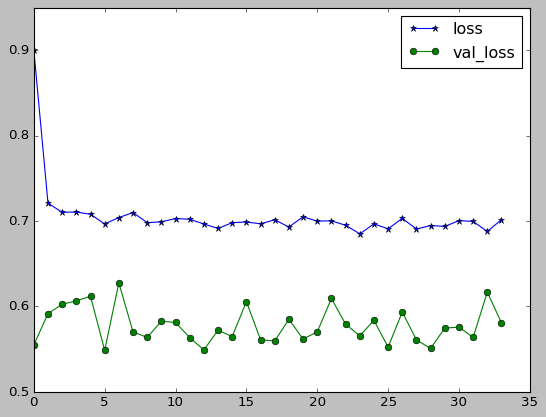

In [39]:
plt.plot(wbm.history['loss'], '-*',label='loss')
plt.plot(wbm.history['val_loss'], '-o',label='val_loss')
plt.legend()


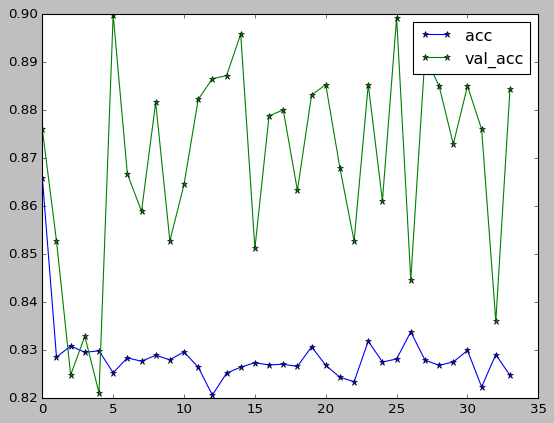

In [40]:
plt.plot(wbm.history['accuracy'],'-*', label='acc')
plt.plot(wbm.history['val_accuracy'],'-*', label='val_acc')
plt.legend()

In [41]:
wbm.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

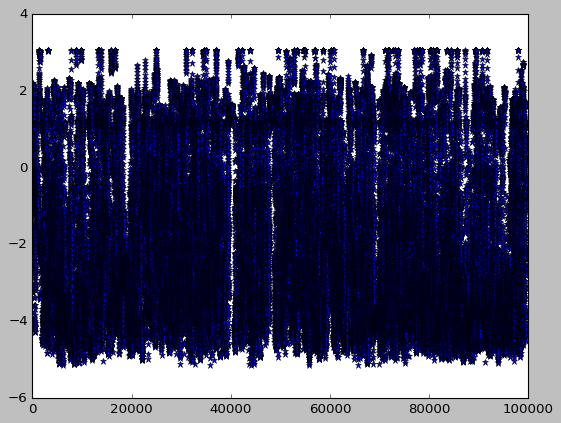

In [42]:
y_pred = model_wl.predict(test_x)
plt.plot(y_pred, '*')

In [43]:
y_pred = model_wl.predict(test_x) >0.5
tf.math.confusion_matrix(test_y, y_pred, num_classes =2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[80487, 17557],
       [  881,   584]], dtype=int32)>

# XY difference

In [44]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out = lstm_20.predict(x)
# np.random.seed(49)
# rand = np.random.permutation(len(out))

In [45]:
xy_diff = []
for i in range(1,len(out)):
    
    xy_diff.append(out[i,:] - out[i-1,:])

xy_diff = np.array(xy_diff)
out =np.sum(np.square(xy_diff[:,0:2]), axis=1)
# out =np.sum(xy_diff[:,0:4], axis=1)
    

### 1)  XY difference from each other

In [46]:
norm_index = np.where(testdict['abnormal'][1:]== 0)
abnorm_index = np.where(testdict['abnormal'][1:]== 1)

Text(0, 0.5, 'Frequency')

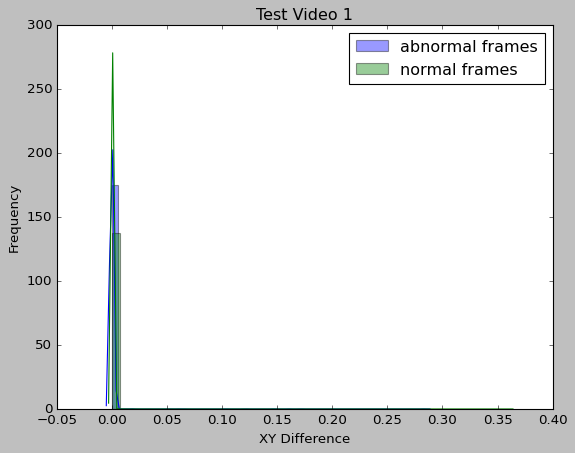

In [47]:
sns.distplot(out[abnorm_index], label='abnormal frames')
sns.distplot(out[norm_index], label='normal frames')
plt.title('Test Video 1')
plt.legend()
plt.xlabel('XY Difference')
plt.ylabel('Frequency')

### 2) XY difference  predicted frame from ground truth

In [ ]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out = lstm_20.predict(x)

In [ ]:
xy_diff = []
for i in range(0,len(out)):
    
    xy_diff.append(out[i,:] - y[i,:])

xy_diff = np.array(xy_diff)
out =np.sum(np.square(xy_diff[:,0:4]), axis=1)

In [ ]:
norm_index = np.where(testdict['abnormal'][1:]== 0)
abnorm_index = np.where(testdict['abnormal'][1:]== 1)

In [ ]:
sns.distplot(out[abnorm_index], label='abnormal frames')
sns.distplot(out[norm_index], label='normal frames')
plt.title('Difference from GT Test Video 2')
plt.legend()
plt.xlabel('XY Difference')
plt.ylabel('Frequency')

In [ ]:
def create_baseline():
    with tf.device('/device:GPU:0'):
        # create model
        model = keras.Sequential()
        model.add(keras.layers.Dense(1, input_dim=1, activation='relu'))
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

In [ ]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)


In [ ]:
results = cross_val_score(estimator, out[rand], testdict['abnormal'][rand], cv=kfold)

In [ ]:
plt.plot(ped[j]['frame_ppl_id'][1:,-1,0], out,'*')
# plt.plot(ped['1']['frame_ppl_id'][1:,-1,0], xy_diff[:,0],'-+')
# plt.plot(ped['1']['frame_ppl_id'][1:,-1,0], xy_diff[:,1],'-0')

In [ ]:
ped[j]['abnormal']

# Abnormal Through IOU

In [ ]:
j ='1'
out1 = lstm_20.predict(ped[j]['x_ppl_box'])
out = norm_train_max_min(data=out1, max1 = max1,min1 =min1,undo_norm=True)
bb_intersection_over_union(xywh_tlbr(out), xywh_tlbr(ped[j]['y_ppl_box']))

# K means Clustering Approach

https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

In [ ]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
out = lstm_20.predict(x)
# out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
# out = np.squeeze(out)
# np.random.seed(49)
# rand = np.random.permutation(len(out))

In [ ]:
# y_pred_scal = model.predict(xx_test)
# y_pred = norm_train_max_min(data=y_pred_scal, max1 = max1,min1 =min1,undo_norm=True)

In [ ]:
kmean_scal = KMeans(n_clusters=2)
kmean = KMeans(n_clusters=2)

In [ ]:
kmean_scal.fit(y_pred_scal[:,0:2])
kmean.fit(y_pred[:,0:2])

In [ ]:
out = kmean_scal.cluster_centers_
out

In [ ]:
out1 = kmean.cluster_centers_
out1

In [ ]:
traindict.keys()

In [ ]:
traindict['frame_ppl_id'][0:3].shape

In [ ]:
ped = pedsort(testdict)

In [ ]:
j='86'
x,y = norm_train_max_min(data_dict=ped[j], max1=max1, min1=min1 )

out1 = model.predict(x)
bb_intersection_over_union(out1,y)

In [ ]:

plt.scatter(y_pred_scal[:,0], y_pred_scal[:,1],s=1, c='b')
plt.scatter(out[0,0], out[0,1],s=200, c ='g', marker='s')
plt.scatter(out[1,0], out[1,1], s=200, c ='r', marker='s')

In [ ]:
plt.scatter(y_pred[:,0], y_pred[:,1],s=1, c='b')
plt.scatter(out1[0,0], out1[0,1],s=200, c ='g', marker='s')
plt.scatter(out1[1,0], out1[1,1], s=200, c ='r', marker='s')

Suggestion that x,y is not enough to create a hyoer parameter to seperate abnomaly and normal pedestrains. Makes sense because abnormal and normal pedestrains walk over the same spatial features. Trying to do it for all pedestrains 